# Goals of the notebook:
    
* Use Machine Learning models to train an NLP classifier to detect which class a text of a subreddit belong

In this notebook, I will be doing the modelling part of the project. I will be trying 2 models:

* RandomForestClassifier
* Naïve Bayes Classifier

In [1]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, make_scorer, accuracy_score, classification_report,f1_score,precision_score,recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords 
pd.options.mode.chained_assignment = None 

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kelvin.liew\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kelvin.liew\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Makeup Subreddit

In [3]:
# read makeup csv
mkp_df = pd.read_csv('clean_makeup.csv')

In [4]:
# check a sample of the data
mkp_df.sample(5)

,subreddit,full_text,tokens,lem
1003,Makeup,Happy Feet Nourishment and Care[removed],"['Happy', 'Feet', 'Nourishment', 'and', 'Care'...",happy feet nourishment and care removed
633,Makeup,What a long wearing foundation that looks flaw...,"['What', 'long', 'wearing', 'foundation', 'tha...",what long wearing foundation that look flawles...
987,Makeup,Good blush colours for deep dark skin? (Nw58)S...,"['Good', 'blush', 'colours', 'for', 'deep', 'd...",good blush colour for deep dark skin nw so try...
379,Makeup,Cruelty Free Concealer from Sephora. What bran...,"['Cruelty', 'Free', 'Concealer', 'from', 'Seph...",cruelty free concealer from sephora what brand...
57,Makeup,Struggling to find a magenta/fuschia purple ey...,"['Struggling', 'to', 'find', 'magenta', 'fusch...",struggling to find magenta fuschia purple eyes...


In [5]:
# rename the lem column
mkp_df.rename(columns={'lem': 'clean_text'}, inplace=True)

## Travel Subreddit

In [6]:
#read fragrance csv
trvl_df = pd.read_csv('clean_travel.csv')

In [7]:
trvl_df.sample(5)

,subreddit,full_text,tokens,lem
860,travel,"Advice for car renting in TurkeyHi r\\travel,\...","['Advice', 'for', 'car', 'renting', 'in', 'Tur...",advice for car renting in turkeyhi travel plan...
64,travel,One Of My Beautiful Moment On Hill.[removed],"['One', 'Of', 'My', 'Beautiful', 'Moment', 'On...",one of my beautiful moment on hill removed
749,travel,travelling to Bolivia this July and planning o...,"['travelling', 'to', 'Bolivia', 'this', 'July'...",travelling to bolivia this july and planning o...
463,travel,Ibiza - but for mid 30's couple?Wife and I wen...,"['Ibiza', 'but', 'for', 'mid', 'couple', 'Wife...",ibiza but for mid couple wife and went to ibiz...
136,travel,Greece this Summer3 of us are heading to Greec...,"['Greece', 'this', 'Summer', 'of', 'us', 'are'...",greece this summer of u are heading to greece ...


In [8]:
trvl_df.rename(columns={'lem': 'clean_text'}, inplace=True)

## Data preprocessing
In this step we will combine both dataframes in order to build a one dataframe with texts data from both classes `travel` and `makeup` for modeling stages later.

In [9]:
# combining the 2 dataframes together into 1 datatframe called df
frames = [trvl_df, mkp_df]
data = pd.concat(frames)

In [10]:
# checking 1st 5 rows of df
data.sample(5)

,subreddit,full_text,tokens,clean_text
1044,Makeup,eyeshadow as eyelinerso I’ve recently found th...,"['eyeshadow', 'as', 'eyelinerso', 've', 'recen...",eyeshadow a eyelinerso ve recently found that ...
757,Makeup,Moisturizer pills upNot sure if this is an app...,"['Moisturizer', 'pills', 'upNot', 'sure', 'if'...",moisturizer pill upnot sure if this is an appr...
428,travel,"Hey, can anyone recommend a travel bag for int...","['Hey', 'can', 'anyone', 'recommend', 'travel'...",hey can anyone recommend travel bag for interr...
1204,Makeup,Moisturizer leaves face shinyHello! I currentl...,"['Moisturizer', 'leaves', 'face', 'shinyHello'...",moisturizer leaf face shinyhello currently do ...
123,Makeup,Help with concealer on undereyesApologies if t...,"['Help', 'with', 'concealer', 'on', 'undereyes...",help with concealer on undereyesapologies if t...


in the next coming steps, we won't be using the other 2 columns `full_text` and `tokens` so we will drop them.

In [11]:
data.drop(['full_text', 'tokens'], inplace=True, axis=1)

In this step, we will build a function that gonna preprocess our data to be prepared for machine learning model, the features included in this preprocessing stage are :

1. Lowercase text  
2. Remove whitespace  
3. Remove numbers  
4. Remove special characters  
5. Remove emails  
6. Remove stop words 
7. Remove NAN  
8. Remove weblinks  
9. Expand contractions (if possible not necessary)  
10. Tokenize

In [12]:
lemmatizer = WordNetLemmatizer()

In [13]:
def preprocess(clean_text):
    # lowercase text
    clean_text = str(clean_text)
    clean_text = clean_text.lower() 
    # remove html tags
    clean_text = clean_text.replace('{html}',"")           
    cleanr = re.compile('<.*?>')
    clean_text = re.sub(cleanr, '', clean_text)
    # remove url
    rem_url = re.sub(r'http\S+', '',clean_text)
    # remove numbers
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    # filter stopwords
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    lemma_words=[lemmatizer.lemmatize(w) for w in filtered_words]
    return " ".join(filtered_words)

In [14]:
data['clean_message'] = data['clean_text'].apply(preprocess) 

In [15]:
data.sample(5)

,subreddit,clean_text,clean_message
619,Makeup,salvation removed,salvation removed
818,Makeup,am available for hookup hmu on hangout now cla...,available hookup hmu hangout clarakimber gmail...
717,Makeup,f4m bored and horny at home wanna get fuck sna...,bored horny home wanna get fuck snap jullianke...
547,Makeup,rare beauty positive light tinted moisturizer ...,rare beauty positive light tinted moisturizer ...
1227,Makeup,does anyone here struggle to put on lipstick h...,anyone struggle put lipstick hello research pr...


In [16]:
# selecting the necessary columns into df
data = data[['subreddit', 'clean_message']]

In [17]:
# save the cleaned df to csv
data.to_csv('cleaned_subreddit.csv', index=False)

# Converting our subreddit column:  

Converting makeup/travel into binary labels    
* 0 stands for travel  
* 1 stands for makeup  

In [18]:
data['subreddit'] = data['subreddit'].map({'travel':0, 'Makeup':1})

In [19]:
data.sample(5)

,subreddit,clean_message
1249,1,literally nothing cover dark circlesi use colo...
964,1,survey removed
97,1,sun day makeup helpi work long hour day sun le...
1073,1,becca mineral blush flowerchild laura mercier ...
292,1,makeup product make eye tear upas title say bu...


In [20]:
data['subreddit'].value_counts()

1    1369
0     973
Name: subreddit, dtype: int64

I did a value count to ensure there is no data imbalance. As we can see, the subreddits have slightly a gap of 430 rows. Hence we are going to rebalance the data by undersamling the most dominated subreddit.

In [21]:
def sampling_k_elements(group, k=946):
    if len(group) < k:
        return group
    return group.sample(k)

balanced_df = data.groupby('subreddit').apply(sampling_k_elements).reset_index(drop=True)

In [22]:
balanced_df['subreddit'].value_counts()

0    946
1    946
Name: subreddit, dtype: int64

# Modelling
Cross-validation is a common method to evaluate the performance of a text classifier. It works by splitting the training dataset into random, equal-length example sets( in this case, we have 70% training set and 30% test set). For each set, a text classifier is trained with the remaining samples. Next, the classifiers make predictions on their respective sets, and the results are compared against the human-annotated tags. This will determine when a prediction was right (true positives and true negatives) and when it made a mistake (false positives, false negatives).

In [23]:
X = balanced_df['clean_message']
y = balanced_df['subreddit']

## Data spliting

In [24]:
# split the data into the training and testing sets with 70% training set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y, random_state = 42)

In [25]:
print(f"The training dataset has {X_train.shape[0]} rows and the test set has {X_test.shape[0]} rows")

The training dataset has 1324 rows and the test set has 568 rows


# Baseline Model: RandomForestClassifier
### RandomForestClassifier: 

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default), otherwise the whole dataset is used to build each tree.

### Count Vectorization
It converts a collection of text documents to a matrix of token counts. 

### Pipeline
I am using a pipeline with CountVectorizer & RandomForest Classifier in order to search through a few parameters that I have picked so that I am able to get a better results from a series of parameters.

For count vectorization, the parameters that I will be searching through are:

* stop_words: {‘english’} or none. However, I have already dropped certain words earlier that I do not want to include in modelling. 
* min_df : minimum number of documents needed to include tokens: 2,3
* max_df: If a word occurs in more than 0.9 or 0.95, it will get removed.
* n_gram_range: For example an ngram_range of (1, 1) means only unigrams, (1, 2) means unigrams and bigrams, and (2, 3) means bigrams and trigram.
* n_estimators: number of trees in a forest
* max_depth:The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples. I have decided to try a total of 7 variables as I do not wish for my classifier to take too long to get results.  

### Scoring
* AUC & Accuracy is used. There are many other scoring metrics that can be used such as recall, precision and F1. But I have decided to just use 2 metrics as the problem statement is to classify the reddit post to its proper subreddit category.Also, since my data is balanced and weighing the objective of the project, I can safely rely on accuracy score. Hence, I believe that these 2 metrics are sufficient to tell us if our end results are good and the objective has been met. 

* AUC: The Area Under the Curve (AUC) is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve. The higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes. if the AUC is closer to 1, it means that the performance of the model is more accurate at distinguishing between the positive and negative classes.

* Accuracy: Accuracy represents the number of correctly classified data instances over the total number of data instances.

In [26]:
pipe  = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier(random_state=42))])

In [27]:
pipe_params = {
    'cvec__max_features': [900, 1_000],
    'cvec__stop_words': ["english"],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9],
    'cvec__ngram_range': [(1, 1),(1, 2)],
    'rf__n_jobs': [-1],
    'rf__n_estimators': [100,150,200],
    'rf__max_depth': [4, 5, 6],
}

In [28]:
scorers = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

In [29]:
from datetime import datetime
start_time = datetime.now()

In [30]:
# instantiate GridSeachCV
gs = GridSearchCV(pipe, param_grid = pipe_params, cv = 3, scoring = scorers, n_jobs = -1, refit = 'AUC') 

In [31]:
# fit grid search to training data
gs.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.9],
                         'cvec__max_features': [900, 1000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': ['english'],
                         'rf__max_depth': [4, 5, 6],
                         'rf__n_estimators': [100, 150, 200],
                         'rf__n_jobs': [-1]},
             refit='AUC',
             scoring={'AUC': 'roc_auc',
                      'Accuracy': make_scorer(accuracy_score)})

In [32]:
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:28.965602


In [33]:
# score model on test set
gs.score(X_test, y_test)

0.9686074191628645

In [34]:
# get the best params
gs.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 900,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': 'english',
 'rf__max_depth': 6,
 'rf__n_estimators': 200,
 'rf__n_jobs': -1}

In [35]:
#get predictions
preds = gs.predict(X_test)

#save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

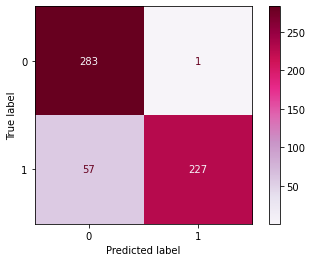

In [36]:
# View confusion matrix
plot_confusion_matrix(gs, X_test, y_test, cmap='PuRd', values_format='d');

Specificity (SP) is calculated as the number of correct negative predictions divided by the total number of negatives. It is also called true negative rate (TNR). The best specificity is 1.0, whereas the worst is 0.0.

In [37]:
# Calculate the specificity
spec = tn / (tn + fp)

print('Specificity:', spec)

Specificity: 0.9964788732394366


Recall is also known as sensitivity or true positive rate. Recall should ideally be 1 (high) for a good classifier. Recall becomes 1 only when the numerator and denominator are equal i.e TP = TP +FN, this also means FN is zero. As FN increases the value of denominator becomes greater than the numerator and recall value decreases (which we don’t want).

In [38]:
# Calculate the recall
recall_rf = tp / (tp + fn)

print('Recall:', recall_rf)

Recall: 0.7992957746478874


In [39]:
#RandomForest AUC/Accuracy Score
rf_auc_train = gs.score(X_train,y_train)
rf_auc_test = gs.score(X_test,y_test)
rf_acc_train = accuracy_score(gs.predict(X_train),y_train)
rf_acc_test = accuracy_score(gs.predict(X_test),y_test)

In [40]:
print(f'RandomForest AUC train score {rf_auc_train}')
print(f'RandomForest AUC test score {rf_auc_test}')
print(f'RandomForest Accuracy train score {rf_acc_train}')
print(f'RandomForest Accuracy test score {rf_acc_test}')

RandomForest AUC train score 0.9786100893566141
RandomForest AUC test score 0.9686074191628645
RandomForest Accuracy train score 0.9123867069486404
RandomForest Accuracy test score 0.897887323943662


## Naive Bayes classifier
Naive Bayes is a family of probabilistic algorithms that take advantage of probability theory and Bayes’ Theorem to predict the tag of a text (like a piece of news or a customer review). They are probabilistic, which means that they calculate the probability of each tag for a given text, and then output the tag with the highest one. The way they get these probabilities is by using Bayes’ Theorem, which describes the probability of a feature, based on prior knowledge of conditions that might be related to that feature.

In [41]:
#Creating Pipeline for Naive Bayes Model
pipe2 = Pipeline([("vec", None), ("model", MultinomialNB())])

param_grid2 = {"vec": [CountVectorizer(), TfidfVectorizer()],
              'vec__max_features': [800, 900, 1_000],
              'vec__stop_words': ["english"],
              'vec__min_df': [2, 3],
              'vec__max_df': [.9, .95],
              'vec__ngram_range': [(1, 1),(1, 2)],     
             }

#gs = GridSearchCV(pipe_tvec, param_grid = pipe_tvec_params, cv=5) 
scorers = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

gs_nb = GridSearchCV(pipe2, param_grid2,cv = 3, scoring = scorers,refit = 'AUC')

In [42]:
start_time = datetime.now()

#Fitting Pipeline into GridSearchCV
gs_nb.fit(X_train, y_train)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:11.128087


In [43]:
#score model on test set
gs_nb.score(X_test, y_test)

0.9927283773060901

In [44]:
#get the best params
gs_nb.best_params_

{'vec': CountVectorizer(max_df=0.9, max_features=1000, min_df=3, stop_words='english'),
 'vec__max_df': 0.9,
 'vec__max_features': 1000,
 'vec__min_df': 3,
 'vec__ngram_range': (1, 1),
 'vec__stop_words': 'english'}

In [45]:
#get predictions
preds2 = gs_nb.predict(X_test)

#save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds2).ravel()

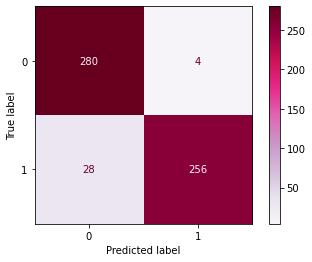

In [46]:
# View confusion matrix
plot_confusion_matrix(gs_nb, X_test, y_test, cmap='PuRd', values_format='d');

Specificity (SP) is calculated as the number of correct negative predictions divided by the total number of negatives. It is also called true negative rate (TNR). The best specificity is 1.0, whereas the worst is 0.0.

In [47]:
# Calculate the specificity
spec_nb = tn / (tn + fp)

print('Specificity:', spec_nb)

Specificity: 0.9859154929577465


Recall is also known as sensitivity or true positive rate. Recall should ideally be 1 (high) for a good classifier. Recall becomes 1 only when the numerator and denominator are equal i.e TP = TP +FN, this also means FN is zero. As FN increases the value of denominator becomes greater than the numerator and recall value decreases (which we don’t want).

In [48]:
# Calculate the recall
recall_nb = tp / (tp + fn)

print('Recall:', recall_nb)

Recall: 0.9014084507042254


In [49]:
# AUC/Accuracy Score
aucnb_train = gs_nb.score(X_train,y_train)
aucnb_test = gs_nb.score(X_test,y_test)
accnb_train = accuracy_score(gs_nb.predict(X_train),y_train)
accnb_test = accuracy_score(gs_nb.predict(X_test),y_test)

In [50]:
print(f'Naive Bayes AUC train score {aucnb_train}')
print(f'Naive Bayes AUC test score {aucnb_test}')
print(f'Naive Bayes Accuracy train score {accnb_train}')
print(f'Naive Bayes Accuracy test score {accnb_test}')

Naive Bayes AUC train score 0.9969834156314747
Naive Bayes AUC test score 0.9927283773060901
Naive Bayes Accuracy train score 0.9622356495468278
Naive Bayes Accuracy test score 0.9436619718309859


In [51]:
print(f'Naive Bayes AUC train score {aucnb_train}')
print(f'Naive Bayes AUC test score {aucnb_test}')
print(f'Naive Bayes Accuracy train score {accnb_train}')
print(f'Naive Bayes Accuracy test score {accnb_test}')
print(f'Naive Bayes Specificity {spec_nb}')
print(f'Naive Bayes Recall {recall_nb}')
print('----------------------------------------------')
print('')
print(f'RandomForest AUC train score {rf_auc_train}')
print(f'RandomForest AUC test score {rf_auc_test}')
print(f'RandomForest Accuracy train score {rf_acc_train}')
print(f'RandomForest Accuracy test score {rf_acc_test}')
print(f'RandomForest Specificity {spec}')
print(f'RandomForest Recall {recall_rf}')
print('----------------------------------------------')


Naive Bayes AUC train score 0.9969834156314747
Naive Bayes AUC test score 0.9927283773060901
Naive Bayes Accuracy train score 0.9622356495468278
Naive Bayes Accuracy test score 0.9436619718309859
Naive Bayes Specificity 0.9859154929577465
Naive Bayes Recall 0.9014084507042254
----------------------------------------------

RandomForest AUC train score 0.9786100893566141
RandomForest AUC test score 0.9686074191628645
RandomForest Accuracy train score 0.9123867069486404
RandomForest Accuracy test score 0.897887323943662
RandomForest Specificity 0.9964788732394366
RandomForest Recall 0.7992957746478874
----------------------------------------------


In [52]:
print(f'Diff in NB AUC score {aucnb_train - aucnb_test }')
print(f'Diff in NB accuracy score {accnb_train - accnb_test }')
print('----------------------------------------------')
print('')
print(f'Diff in RF AUC score {rf_auc_train - rf_auc_test }')
print(f'Diff in RF accuracy score {rf_acc_train - rf_acc_test }')

Diff in NB AUC score 0.004255038325384652
Diff in NB accuracy score 0.018573677715841952
----------------------------------------------

Diff in RF AUC score 0.010002670193749563
Diff in RF accuracy score 0.014499383004978439


# Conclusion, Recommendation

####  Both models are able to classify which subreddit a post has been given to.
    
           
####  Best model recommendation: Naive Bayes        
     
    * difference between the test/training AUC score and accuracy score is less than 0.0011
    * AUC score and accuracy score is also the highest
    * Lower false negative and false positive
    * Higher Recall(True Positive rate)   
         

####  Best Parameters for NB:
```{'vec': CountVectorizer(max_df=0.9, max_features=800, min_df=2, ngram_range=(1, 2),
                 stop_words='english'),
 'vec__max_df': 0.9,
 'vec__max_features': 800,
 'vec__min_df': 2,
 'vec__ngram_range': (1, 2),
 'vec__stop_words': 'english'}


#### Future Steps:
* Explore with other different models
* Select features that are important and see if it can give a better results
* Explore more with hyperparameter tuning